In [1]:
# %%
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import keras.utils as image
from keras.applications.mobilenet import MobileNet
from keras.models import Model
from keras.layers import GlobalAveragePooling2D
from sklearn.metrics import matthews_corrcoef
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [5]:
# %%
# Define directories
train_dir = 'C:/Users/dhruv/Desktop/project/CyberVision-Advanced-Visual-Malware-Classification-main/malimg_dataset/train'
test_dir = 'C:/Users/dhruv/Desktop/project/CyberVision-Advanced-Visual-Malware-Classification-main/malimg_dataset/test'

# %%
image_size = (224, 224, 3)

In [3]:
# %%
def load_images(directory):
    images = []
    labels = []
    for label, class_name in enumerate(os.listdir(directory)):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):  # Check if it's a directory
            for filename in os.listdir(class_dir):
                img_path = os.path.join(class_dir, filename)
                img = image.load_img(img_path, target_size=image_size)
                img_array = image.img_to_array(img)
                images.append(img_array)
                labels.append(label)
    return np.array(images), np.array(labels)

In [6]:
# %%
# Load training and test images
train_images, train_labels = load_images(train_dir)
test_images, test_labels = load_images(test_dir)

# Preprocess images
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0


In [7]:
# %%
# Load MobileNet with pre-trained weights on ImageNet
base_mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='None')

# Add Global Average Pooling (GAP) layer
x = base_mobilenet.output
x = GlobalAveragePooling2D()(x)

# Create the model
mobilenet_with_gap = Model(inputs=base_mobilenet.input, outputs=x)

In [8]:
# Function to extract features in batches
def extract_features(model, images, batch_size):
    num_images = images.shape[0]
    features = []
    for start_idx in range(0, num_images, batch_size):
        end_idx = min(start_idx + batch_size, num_images)
        batch = images[start_idx:end_idx]
        batch_features = model.predict(batch)
        features.append(batch_features)
    return np.concatenate(features)

In [9]:
# Extract features using the model without the top layer in batches
batch_size = 8  # Adjust based on GPU memory
train_features = extract_features(mobilenet_with_gap, train_images, batch_size)
test_features = extract_features(mobilenet_with_gap, test_images, batch_size)

1/1 [==============================] - 0s 60ms/step


In [10]:
# %%
# Define the parameter grid for Naive Bayes
nb_param_grid = {}  # No hyperparameters for Gaussian Naive Bayes

# Create a Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()

# Use GridSearchCV to find the best parameters for Naive Bayes
nb_grid_search = GridSearchCV(nb_classifier, nb_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
nb_grid_search.fit(train_features, train_labels)

# Get the best parameters for Naive Bayes
best_nb_params = nb_grid_search.best_params_

# Use the best parameters to train the final Naive Bayes model
final_nb_classifier = GaussianNB(**best_nb_params)
start_time_nb = time.time()
final_nb_classifier.fit(train_features, train_labels)
train_time_nb = time.time() - start_time_nb

# Predict labels for the test set using Naive Bayes
nb_predictions = final_nb_classifier.predict(test_features)

# Evaluate accuracy for Naive Bayes
nb_accuracy = accuracy_score(test_labels, nb_predictions)
print("\nBest Naive Bayes Parameters:", best_nb_params)
print("Naive Bayes Accuracy:", nb_accuracy)


Best Naive Bayes Parameters: {}
Naive Bayes Accuracy: 0.896551724137931


In [11]:
# Additional evaluation metrics for Naive Bayes
precision_nb = precision_score(test_labels, nb_predictions, average='weighted')
recall_nb = recall_score(test_labels, nb_predictions, average='weighted')
f1_nb = f1_score(test_labels, nb_predictions, average='weighted')

print("Train Time (sec) Naive Bayes:", train_time_nb)
# If you used GridSearchCV, you can access the training time with `cv_results_`
grid_train_time_nb = nb_grid_search.cv_results_['mean_fit_time'][nb_grid_search.best_index_]
print("Train Time (sec) Grid Naive Bayes:", grid_train_time_nb)

# Calculate Matthews Correlation Coefficient (MCC) for Naive Bayes
mcc_nb = matthews_corrcoef(test_labels, nb_predictions)
print("Matthews Correlation Coefficient (MCC) Naive Bayes:", mcc_nb)

# Accuracy for optimization algorithm (GridSearchCV)
optimization_accuracy = nb_grid_search.best_score_
print("Optimization Algorithm Accuracy:", optimization_accuracy)


Train Time (sec) Naive Bayes: 0.03702068328857422
Train Time (sec) Grid Naive Bayes: 0.05188560485839844
Matthews Correlation Coefficient (MCC) Naive Bayes: 0.8832874848766693
Optimization Algorithm Accuracy: 0.9025316736868132


In [12]:

# Confusion matrix for Naive Bayes
conf_matrix_nb = confusion_matrix(test_labels, nb_predictions)
precision_nb = precision_score(test_labels, nb_predictions, average='weighted')

FP_nb = conf_matrix_nb.sum(axis=0) - np.diag(conf_matrix_nb)  
FN_nb = conf_matrix_nb.sum(axis=1) - np.diag(conf_matrix_nb)
TP_nb = np.diag(conf_matrix_nb)
TN_nb = conf_matrix_nb.sum()

In [13]:

# %%
# Display results for Naive Bayes
print("\nResults for Naive Bayes:")
print("Precision (Naive Bayes):", precision_nb)
print("Recall (Naive Bayes):", recall_nb)
print("F1 Score (Naive Bayes):", f1_nb)
print("True Positive Rate (TPR) (Naive Bayes):", np.mean(TP_nb / (TP_nb + FN_nb)))
print("True Negative Rate (TNR) (Naive Bayes):", np.mean(TN_nb / (TN_nb + FP_nb)))
print("False Positive Rate (FPR) (Naive Bayes):", np.mean(FP_nb / (FP_nb + TN_nb)))
print("False Negative Rate (FNR) (Naive Bayes):", np.mean(FN_nb / (TP_nb + FN_nb)))

print("False Discovery Rate (FDR) (Decision Tree):", np.mean(FP_nb / (FP_nb + TP_nb)))
print("False Omission Rate (FOR) (Decision Tree):", np.mean(FN_nb / (FN_nb + TN_nb)))
print("Matthews Correlation Coefficient (MCC) (Naive Bayes):", mcc_nb)



Results for Naive Bayes:
Precision (Naive Bayes): 0.9355966687394557
Recall (Naive Bayes): 0.896551724137931
F1 Score (Naive Bayes): 0.9103885400925861
True Positive Rate (TPR) (Naive Bayes): 0.8700350780853877
True Negative Rate (TNR) (Naive Bayes): 0.9959543060776666
False Positive Rate (FPR) (Naive Bayes): 0.004045693922333362
False Negative Rate (FNR) (Naive Bayes): 0.1299649219146123
False Discovery Rate (FDR) (Decision Tree): 0.13245467386643858
False Omission Rate (FOR) (Decision Tree): 0.004022934093681812
Matthews Correlation Coefficient (MCC) (Naive Bayes): 0.8832874848766693


In [14]:
conf_matrix_nb

array([[ 11,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   0,   0],
       [  0,  13,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 246,   0,   0,   0,   1,   7,   0,   0,   0,   0,   0,
          0,   0,   0,  40,   0,   0,   0,   0,   0,   0,   2,   0],
       [  0,   0,   1, 159,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  21,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  12,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  12,   3,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   2,   0,   3,   0,   0,   0,   0],
      

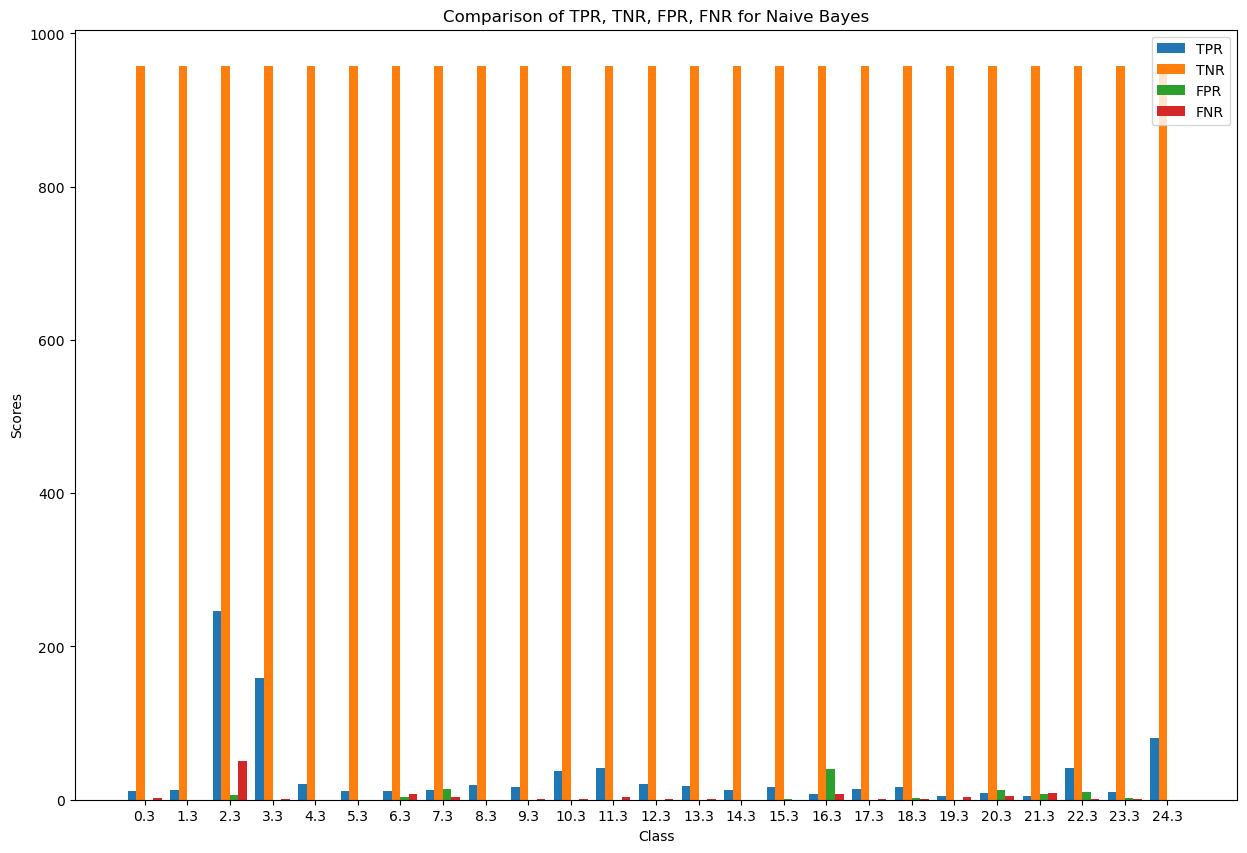

In [15]:
# Plot TPR, TNR, FPR, FNR
fig, ax = plt.subplots(figsize=(15, 10))

bar_width = 0.2
index = np.arange(25)  # Assuming you have 25 classes, adjust this based on your data

bar1 = ax.bar(index, TP_nb, bar_width, label='TPR')
bar2 = ax.bar(index + bar_width, TN_nb, bar_width, label='TNR')
bar3 = ax.bar(index + 2 * bar_width, FP_nb, bar_width, label='FPR')
bar4 = ax.bar(index + 3 * bar_width, FN_nb, bar_width, label='FNR')

ax.set_xlabel('Class')
ax.set_ylabel('Scores')
ax.set_title('Comparison of TPR, TNR, FPR, FNR for Naive Bayes')
ax.set_xticks(index + 1.5 * bar_width)
ax.legend()

plt.show()

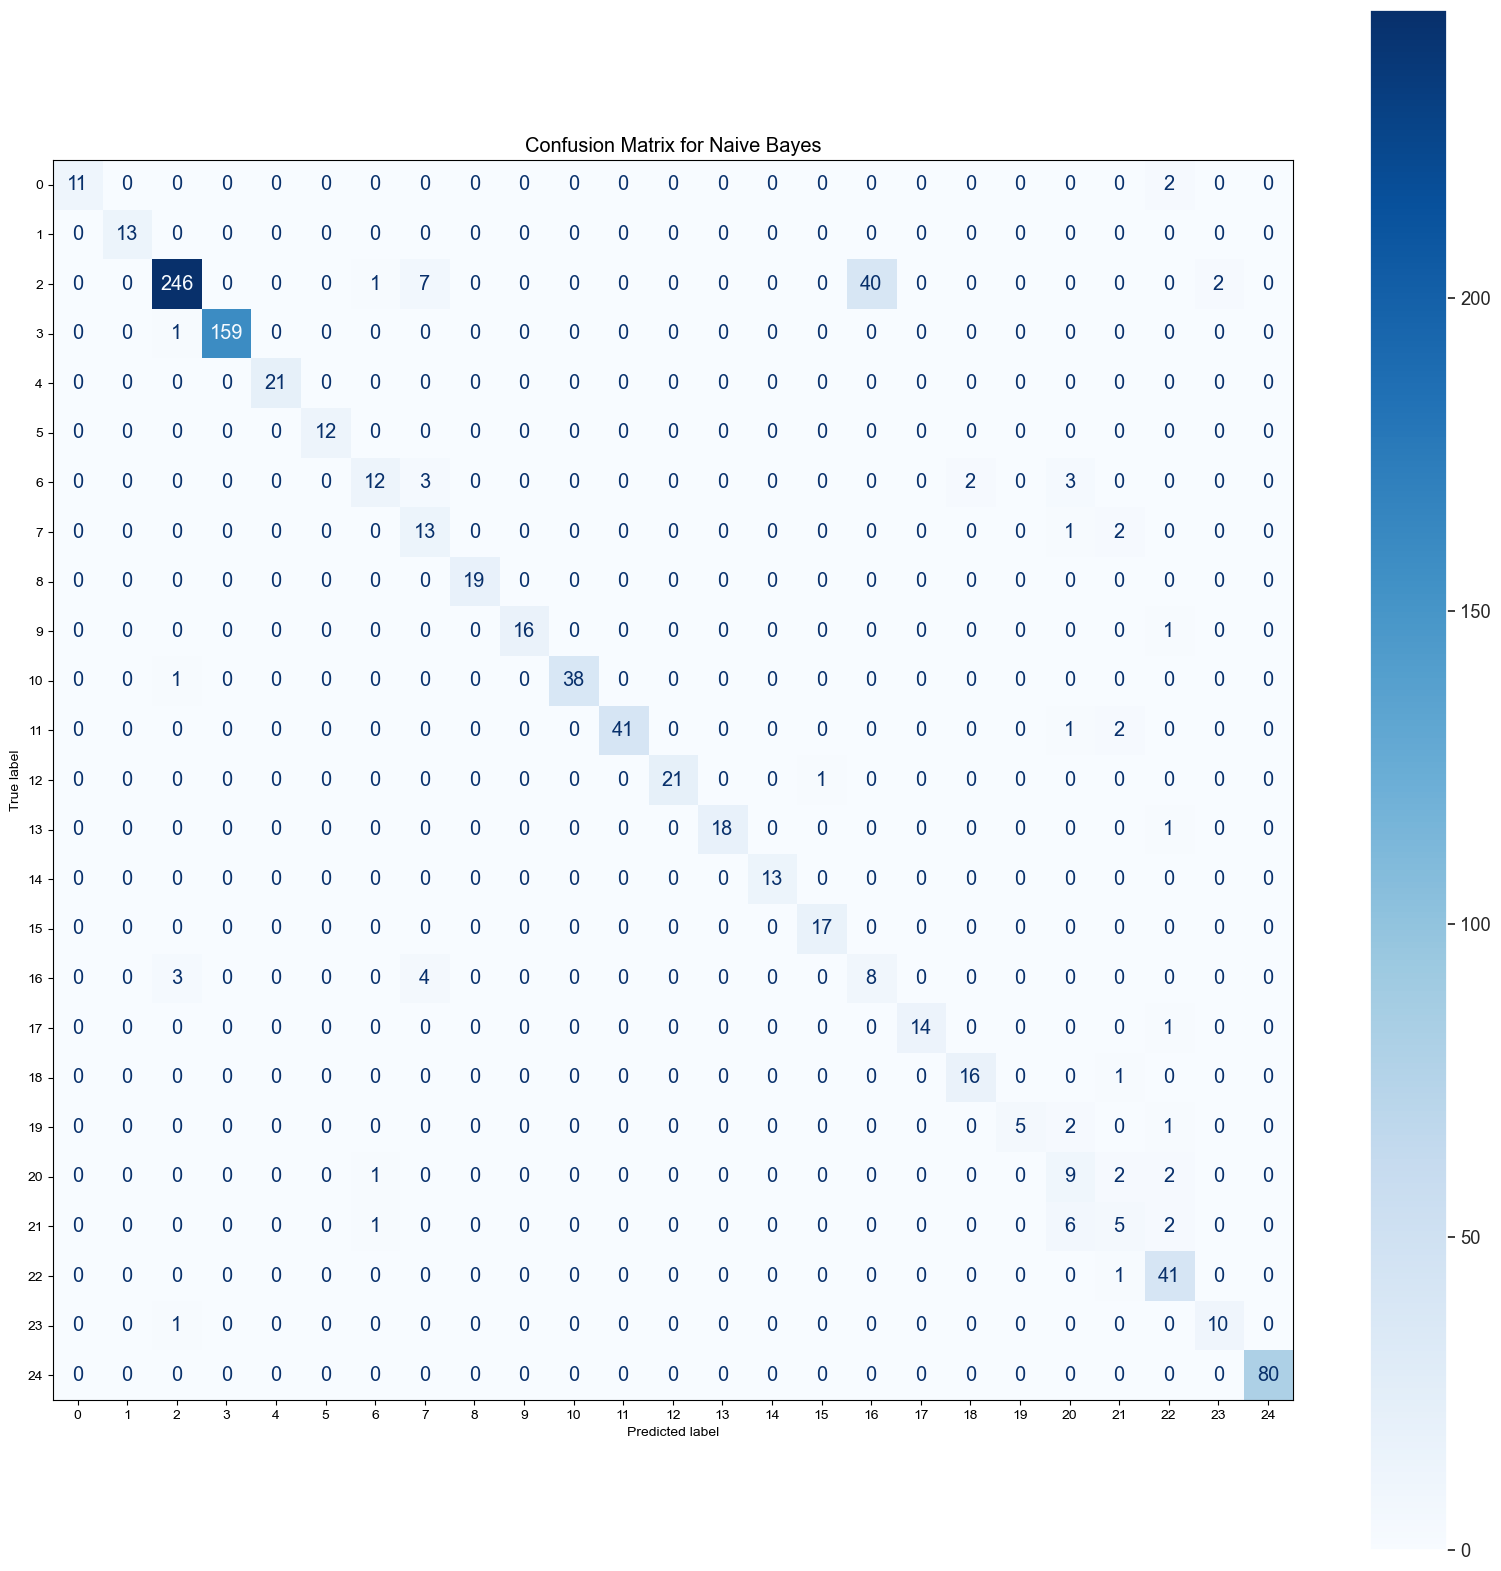

In [16]:
# Plot Confusion Matrix for Naive Bayes
fig, ax = plt.subplots(figsize=(20, 20))
sns.set(font_scale=1.2)  # Adjust font size for better readability
disp = ConfusionMatrixDisplay(conf_matrix_nb, display_labels=np.unique(test_labels))
disp.plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix for Naive Bayes')
plt.show()